**Load the required Libraries**

In [2]:
!pip install transformers datasets torch scikit-learn

from datasets import load_dataset
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_scheduler
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
from transformers import T5Tokenizer

# Initialize the T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

# Tokens list
tokens = ['▁Core', 'ference', '▁resolution', ':', '▁Mark', '▁told', '▁Pete', '▁many',
          '▁lies', '▁about', '▁himself', ',', '▁which', '▁Pete', '▁included', '▁in',
          '▁his', '▁book', '.', '▁He', '▁should', '▁have', '▁been', '▁more', '▁skeptical',
          '.', '▁Does', '▁', "'", 'He', "'", '▁refer', '▁to', '▁', "'", 'Mark', "'", '?']

# Convert tokens to IDs
token_ids = tokenizer.convert_tokens_to_ids(tokens)

# Print token IDs
print(token_ids)


[9020, 11788, 3161, 10, 2185, 1219, 19786, 186, 7797, 81, 2448, 6, 84, 19786, 1285, 16, 112, 484, 5, 216, 225, 43, 118, 72, 27716, 5, 3520, 3, 31, 3845, 31, 2401, 12, 3, 31, 19762, 31, 58]


**Download and Preprocess the WSC Dataset**

In [4]:
# Load the WSC dataset
def preprocess_wsc_data():
    # Download the WSC dataset from the SuperGLUE benchmark
    wsc = load_dataset("super_glue", "wsc")

    # Preprocess the data
    def preprocess(ex):
        sentence = ex['text']
        pronoun = ex['span2_text']
        candidate = ex['span1_text']
        label = "true" if ex['label'] == 1 else "false"

        # Formatting input text for T5
        input_text = f"resolve: {sentence}\nPronoun: {pronoun}\nCandidate: {candidate}"
        target_text = label

        return {"input_text": input_text, "target_text": target_text}

    # Apply the preprocessing function and remove irrelevant columns
    train_data = wsc['train'].map(preprocess, remove_columns=['text', 'span1_text', 'span2_text', 'label'])
    val_data = wsc['validation'].map(preprocess, remove_columns=['text', 'span1_text', 'span2_text', 'label'])

    return train_data, val_data

train_data, val_data = preprocess_wsc_data()


train_df = train_data.to_pandas()
train_df
val_df = val_data.to_pandas()
val_df



README.md:   0%|          | 0.00/18.2k [00:00<?, ?B/s]

super_glue.py:   0%|          | 0.00/30.7k [00:00<?, ?B/s]

The repository for super_glue contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/super_glue.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/554 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/104 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/146 [00:00<?, ? examples/s]

Map:   0%|          | 0/554 [00:00<?, ? examples/s]

Map:   0%|          | 0/104 [00:00<?, ? examples/s]

,span1_index,span2_index,idx,input_text,target_text
0,32,47,0,"resolve: Bernard , who had not told the govern...",false
1,0,39,1,resolve: Mr. Moncrieff visited Chester 's luxu...,true
2,13,17,2,resolve: I tried to paint a picture of an orch...,false
3,2,20,3,"resolve: Always before, Larry had helped Dad w...",false
4,1,14,4,resolve: Since Chester was dependent on Uncle ...,false
...,...,...,...,...,...
99,4,39,99,resolve: Every day after dinner Mr. Schmidt to...,true
100,0,8,100,resolve: Bill passed the half-empty plate to J...,false
101,14,19,101,"resolve: Meanwhile, in the forest, the elephan...",true
102,5,20,102,"resolve: Always before, Larry had helped Dad w...",true


In [45]:
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

tokenizer = T5Tokenizer.from_pretrained('t5-small')  # or 't5-large' depending on your choice
#model = T5ForConditionalGeneration.from_pretrained('t5-small')
from transformers import T5Config

# Create a custom T5 configuration
config = T5Config(
    num_layers=6,          # Encoder and decoder layers
    num_decoder_layers=6,  # Decoder layers (if different)
    d_model=512,           # Hidden size
    dropout_rate=0.1      # Dropout
)

# Initialize model with custom config
model = T5ForConditionalGeneration(config=config)
# Move model to the correct device (e.g., CUDA if available)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Assuming 'train_data' and 'val_data' are already preprocessed datasets

# Create a clean and simple structure for the training data (no tokenization yet)
train_input_text = [data['input_text'] for data in train_data]
train_target_text = [data['target_text'] for data in train_data]

# Create a DataFrame to easily inspect the preprocessed data before tokenization
train_df = pd.DataFrame({
    "input_text": train_input_text,
    "target_text": train_target_text
})

# Display the first few rows to verify
train_df

,input_text,target_text
0,resolve: Mark told Pete many lies about himsel...,false
1,resolve: The mothers of Arthur and Celeste hav...,false
2,resolve: Mark was close to Mr. Singer 's heels...,false
3,"resolve: The pony behaved well, sir, and showe...",true
4,resolve: I poured water from the bottle into t...,true
...,...,...
549,resolve: The sun was covered by a thick cloud ...,false
550,"resolve: Stretching her back, the woman smiled...",false
551,resolve: Bill passed the gameboy to John becau...,false
552,resolve: Fred and Alice had very warm down coa...,true


**Tokenize the Data**

In [46]:
from transformers import T5Tokenizer

# Load T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

# Tokenize the dataset in batches
def tokenize_data(dataset, tokenizer, max_length=512):
    # Tokenize input and target texts and pad them
    input_encodings = tokenizer(
        dataset['input_text'],
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt"
    )
    target_encodings = tokenizer(
        dataset['target_text'],
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt"
    )

    # Add the target labels to the input encodings explicitly
    input_encodings['labels'] = target_encodings['input_ids']

    # Returning the tokenized dataset
    return input_encodings

# Tokenizing the entire dataset
train_encodings = tokenize_data(train_data, tokenizer)
val_encodings = tokenize_data(val_data, tokenizer)


**Create PyTorch Dataset(Batch size 16)**

In [47]:
# # import torch

# class WSCDataset(torch.utils.data.Dataset):
#     def __init__(self, encodings):
#         self.encodings = encodings

#     def __len__(self):
#         return len(self.encodings['input_ids'])

#     def __getitem__(self, idx):
#         item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
#         return item

# train_dataset = WSCDataset(train_encodings)
# val_dataset = WSCDataset(val_encodings)

class WSCDataset(Dataset):
    def __init__(self, encodings):
        """
        Initializes the dataset with tokenized encodings.
        The dataset includes input_ids, attention_mask, and labels (target_ids).
        """
        self.encodings = encodings

    def __len__(self):
        """Returns the total number of samples in the dataset"""
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        """Returns the item at the given index"""
        # For efficiency, directly return the encodings as tensors
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

# Create the dataset instances
train_dataset = WSCDataset(train_encodings)
val_dataset = WSCDataset(val_encodings)

# Create DataLoader instances for efficient batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Example: Iterate through the data to verify
for batch in train_loader:
    input_ids = batch['input_ids']
    labels = batch['labels']
    attention_mask = batch['attention_mask']
    print(input_ids.shape, labels.shape, attention_mask.shape)
    break  # Just checking the first batch


torch.Size([16, 140]) torch.Size([16, 2]) torch.Size([16, 140])


<ipython-input-47-27ec9d8c0877>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


**Set Up the T5 Model**

In [48]:
# Load the T5 model
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Check if CUDA is available and move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Verify model and device setup
print(f"Model is loaded on {device}.")

# Optionally set the model to evaluation mode if you're not training right now
model.eval()

# You can also disable gradients during evaluation for memory efficiency
# Use the model in inference mode (during validation or testing):


Model is loaded on cuda.


T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

**Define Training Parameters**

In [49]:
# Hyperparameters
batch_size = 8                # Batch size for training
epochs = 5                # Number of training epochs
learning_rate = 5e-4           # Learning rate for the optimizer
warmup_ratio = 0.1             # Ratio of warmup steps (10% of total steps)
max_length = 512               # Maximum length of input sequences
# gradient_accumulation_steps = 1 # Number of gradient accumulation steps (useful for simulating larger batch sizes)

# Device (CUDA if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Optimizer and Scheduler settings
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Calculate the total number of training steps
num_training_steps = epochs * len(train_loader)
num_warmup_steps = int(warmup_ratio * num_training_steps)

# Linear scheduler with warmup
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

# # Print summary of parameters
# print(f"Training Parameters: ")
# print(f" - Batch Size: {batch_size}")
# print(f" - Epochs: {epochs}")
# print(f" - Learning Rate: {learning_rate}")
# print(f" - Warmup Steps: {num_warmup_steps}")
# print(f" - Total Training Steps: {num_training_steps}")
# print(f" - Max Sequence Length: {max_length}")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


**Train the Model**

In [50]:
def train_model(model, train_loader, val_loader, epochs, optimizer, scheduler, device):
    # Set the model to training mode
    model.train()

    for epoch in range(epochs):
        total_loss = 0

        # Create a tqdm progress bar for the training loop
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch")

        for batch in train_loop:
            # Move batch data to the correct device (GPU or CPU)
            inputs = {key: val.to(device) for key, val in batch.items()}

            # Zero gradients from the previous step
            optimizer.zero_grad()

            # Forward pass through the model
            outputs = model(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                labels=inputs['labels']
            )

            # Calculate the loss and backpropagate
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Accumulate the loss for reporting
            total_loss += loss.item()

            # Update the progress bar with the current loss
            train_loop.set_postfix(loss=total_loss / (train_loop.n + 1))  # Average loss so far

        # Print average training loss for the epoch
        print(f"Epoch {epoch + 1}, Training Loss: {total_loss / len(train_loader)}")

        # Validation phase
        model.eval()
        total_val_loss = 0

        # No gradients needed for validation
        with torch.no_grad():
            # Create a tqdm progress bar for the validation loop
            val_loop = tqdm(val_loader, desc="Validation", unit="batch")
            for batch in val_loop:
                # Move batch data to the correct device
                inputs = {key: val.to(device) for key, val in batch.items()}

                # Forward pass (no backward pass for validation)
                outputs = model(
                    input_ids=inputs['input_ids'],
                    attention_mask=inputs['attention_mask'],
                    labels=inputs['labels']
                )

                # Accumulate validation loss
                total_val_loss += outputs.loss.item()

                # Update the progress bar with the current validation loss
                val_loop.set_postfix(val_loss=total_val_loss / (val_loop.n + 1))  # Average val loss

        # Print the validation loss for the epoch
        print(f"Validation Loss: {total_val_loss / len(val_loader)}")

        # Set the model back to training mode
        model.train()

        # Optionally: Save model checkpoint after each epoch
        # torch.save(model.state_dict(), f"checkpoint_epoch_{epoch + 1}.pt")

# Run the training loop
train_model(model, train_loader, val_loader, epochs, optimizer, scheduler, device)



Epoch 1/5:   0%|          | 0/35 [00:00<?, ?batch/s]<ipython-input-47-27ec9d8c0877>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 1/5: 100%|██████████| 35/35 [00:04<00:00,  7.48batch/s, loss=2.82]


Epoch 1, Training Loss: 2.821576949954033


Validation: 100%|██████████| 7/7 [00:00<00:00, 38.59batch/s, val_loss=0.917]


Validation Loss: 0.65522443822452


Epoch 2/5: 100%|██████████| 35/35 [00:04<00:00,  7.76batch/s, loss=0.414]


Epoch 2, Training Loss: 0.4138578908784049


Validation: 100%|██████████| 7/7 [00:00<00:00, 38.86batch/s, val_loss=0.468]


Validation Loss: 0.3346292291368757


Epoch 3/5: 100%|██████████| 35/35 [00:04<00:00,  7.49batch/s, loss=0.381]


Epoch 3, Training Loss: 0.3809445440769196


Validation: 100%|██████████| 7/7 [00:00<00:00, 34.16batch/s, val_loss=0.506]


Validation Loss: 0.36174995984349934


Epoch 4/5: 100%|██████████| 35/35 [00:04<00:00,  7.61batch/s, loss=0.391]


Epoch 4, Training Loss: 0.3909520694187709


Validation: 100%|██████████| 7/7 [00:00<00:00, 36.98batch/s, val_loss=0.484]


Validation Loss: 0.3455841456140791


Epoch 5/5: 100%|██████████| 35/35 [00:04<00:00,  7.61batch/s, loss=0.383]


Epoch 5, Training Loss: 0.38329628109931946


Validation: 100%|██████████| 7/7 [00:00<00:00, 37.37batch/s, val_loss=0.475]


Validation Loss: 0.33941446031842915


**Make a prediction vs actual values Table**

In [51]:
# test_predictions_df = pd.DataFrame({
#     "Test Data (Input)": [data['input_text'] for data in test_data],
#     "Predicted Value": predicted_values,
#     "Actual Value": actual_values
# })

# # Display the predictions table
# print(test_predictions_df.head())

**Save the Fine-Tuned Model**

In [52]:
# model.save_pretrained("t5_wsc_finetuned")
# tokenizer.save_pretrained("t5_wsc_finetuned")


**Download the Fine-Tuned Model**

In [53]:
# from google.colab import files
# !zip -r t5_wsc_finetuned.zip t5_wsc_finetuned
# files.download("t5_wsc_finetuned.zip")


**Evaluation Code**

In [54]:


def evaluate_model_and_generate_table_with_text(model, tokenizer, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actuals = []
    input_texts = []  # To store the input text for each prediction
    correct = 0
    total = 0

    # Iterate through validation batches
    for batch in tqdm(val_loader, desc="Evaluating", unit="batch"):
        # Move data to device
        batch = {key: val.to(device) for key, val in batch.items()}

        # Generate predictions
        with torch.no_grad():
            outputs = model.generate(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                max_length=10,  # Adjust max_length as needed
            )

        # Decode predictions and collect the results
        for idx in range(len(batch['input_ids'])):
            prediction = tokenizer.decode(outputs[idx], skip_special_tokens=True).strip().lower()
            target_text = tokenizer.decode(batch['labels'][idx], skip_special_tokens=True).strip().lower()
            input_text = tokenizer.decode(batch['input_ids'][idx], skip_special_tokens=True).strip()

            predictions.append(prediction)
            actuals.append(target_text)
            input_texts.append(input_text)

            # Compare predictions with actuals for accuracy
            if prediction == target_text:
                correct += 1
            total += 1

    # Calculate accuracy
    accuracy = correct / total * 100

    # Create a DataFrame for comparison including input text
    results_df = pd.DataFrame({
        'Input Text': input_texts,
        'Predicted': predictions,
        'Actual': actuals
    })

    print(f"\nPrediction vs Actual Table (Total {len(results_df)} rows):")
    print(results_df.head())  # Display the first few rows of the table
    print(f"\nAccuracy: {accuracy:.2f}%")

    return results_df, accuracy

# Check the length of val_loader dataset before evaluation
print(f"Number of samples in val_loader: {len(val_loader.dataset)}")

# Generate the prediction vs actual table with input text and calculate accuracy
results_df, accuracy = evaluate_model_and_generate_table_with_text(model, tokenizer, val_loader, device)

results_df


Number of samples in val_loader: 104


Evaluating:   0%|          | 0/7 [00:00<?, ?batch/s]<ipython-input-47-27ec9d8c0877>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.03batch/s]


Prediction vs Actual Table (Total 104 rows):
                                          Input Text Predicted Actual
0  resolve: Bernard, who had not told the governm...     false  false
1  resolve: Mr. Moncrieff visited Chester's luxur...     false   true
2  resolve: I tried to paint a picture of an orch...     false  false
3  resolve: Always before, Larry had helped Dad w...      true  false
4  resolve: Since Chester was dependent on Uncle ...      true  false

Accuracy: 59.62%


,Input Text,Predicted,Actual
0,"resolve: Bernard, who had not told the governm...",false,false
1,resolve: Mr. Moncrieff visited Chester's luxur...,false,true
2,resolve: I tried to paint a picture of an orch...,false,false
3,"resolve: Always before, Larry had helped Dad w...",true,false
4,resolve: Since Chester was dependent on Uncle ...,true,false
...,...,...,...
99,resolve: Every day after dinner Mr. Schmidt to...,true,true
100,resolve: Bill passed the half-empty plate to J...,false,false
101,"resolve: Meanwhile, in the forest, the elephan...",false,true
102,"resolve: Always before, Larry had helped Dad w...",true,true


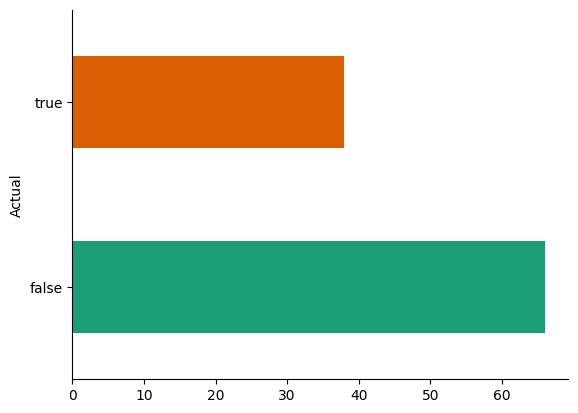

In [55]:
from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('Actual').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)